Stochastic 1D 
=====
***

A one-dimensional stochastic model for the dipole field $x(t)$. The field is generated by a series of impulsive (delta function) events. The event time follows a Poisson process and the event amplitude has a uniform distribution $U(a,b)$.  A small number of negative (destructive) events are permitted by adopting a negative lower limit (a<0), but the average amplitude must be position to sustain the field against diffusive losses. The variance of the dipole moment depends on the range $b-a$. A white noise source with mean 0 and variance $q$ is added to the equation for $x(t)$.

In [1]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles

Draw event times from an exponential distribution

mean recurrence time = 0.0029985175683064744 Myr


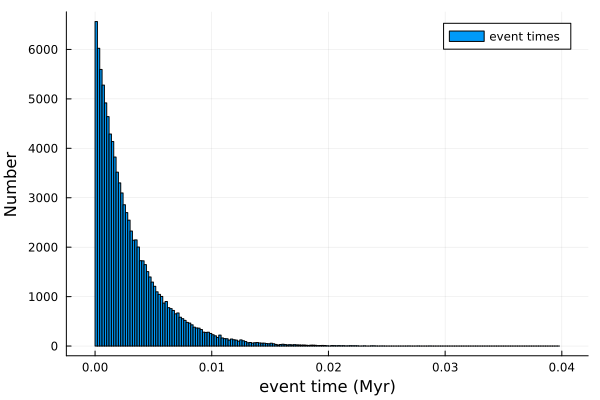

In [2]:
myr = 1.0e6;
recurrence = 3000/myr;         # average recurrence time (Myr)
nevents = 100000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times

# plot distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Specify and sample distribution of event amplitudes

In [3]:
A = 0.195
amp_p = rand(Uniform(0.46*A,4.12*A),nevents)

# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 800;       #  gaussian noise variance

# set level of quenching
x0 = 5.0;

Integrate equations for dipole field. Each event interval $\Delta t$ is divided into two parts. Diffusion causes the dipole to decrease during $\Delta t/2$. Diffusion and a single source event contribute to $x(t)$ over second half of the event interval. Gaussian noise is added at each half time step.

In [4]:
# allocate memory for solution
x = zeros(2*nevents);
t = zeros(2*nevents);

# decay rate for dipole (gamma = 1/tau)
gamma = 0.075 * 1000;    # convert to Myr

# initial condition
t[1] = 0.0;
x[1] = 5.0;
j = 2;

# integrate of number of events
for i = j : nevents
    
    # magnetic diffusion over half time step dt
    dt = tevent[i]/2.0;
    t[j] = t[j-1] + dt;
    gp = exp(-x[j-1]^2/1.8^2);  # x-dependence of gaussian noise
    x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;
    
    # magnetic diffusion over remaining time step
    j += 1;
    t[j] = t[j-1] + dt;
    x[j] = x[j-1] * exp(-gamma * dt)
    
    # evaluate quenching
    fp = 1.0/ (1.0 + (x[j]/x0)^2);
    gp = exp(-x[j]^2/1.8^2);
    
    # add event and random noise
    x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
    j+= 1;
    
end
t[end] = t[end-1]
x[end] = x[end-1]
println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x)))

mean x = 5.328658244780916 std x = 2.0075312683938744


In [5]:
np

200000-element Vector{Float64}:
  0.8569203136200008
 -0.9318628732459363
 -0.0669742316365803
  0.7956118164199603
 -0.06904047067589432
 -0.4088533345241278
  0.4696297980646468
  1.041186993148373
 -0.5036709215756996
  0.39768086111141
 -0.11680109612048224
  1.0965125664837956
  0.7233976424397914
  ⋮
 -0.1386945988994948
  0.3846215693132897
 -1.0696084415663447
 -0.722276141143167
 -0.809358896582609
  1.007858025151421
 -0.9766983133799831
 -1.1946849791669665
 -1.7168507655019694
  1.1348233584832892
  1.011149837890854
 -0.6964567871357128

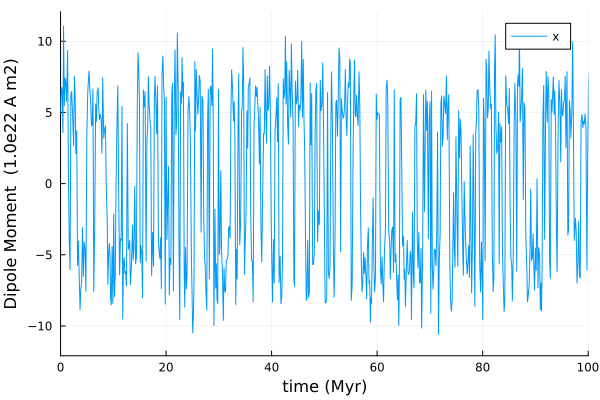

In [6]:
# print time series 
idecimate = 100;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

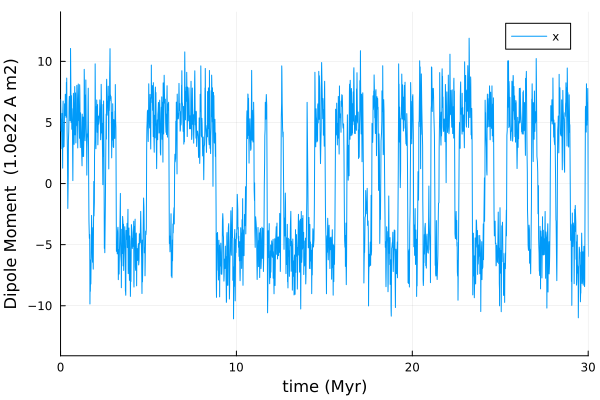

In [7]:
# print time series 
idecimate = 10;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,30))

In [8]:
# save to file ?
save_file = true
      
if save_file
    open("dipole_3000.txt","w")  do io
        writedlm(io,[t x])
    end
end

Plot a histogram of dipole moment

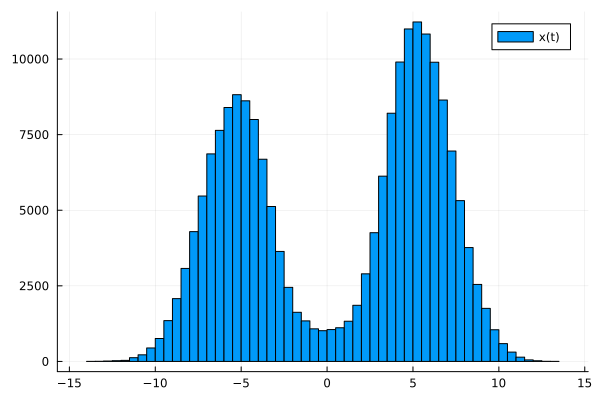

In [9]:
h = fit(Histogram,x,nbins=100)
plot(h,label="x(t)")

Evaluates the mean amplitudes $<A>$, $<A^2>$ and $<A^3>$. Mean and second moment appear in the Fokker-Planck equation.

In [10]:
function moments(A,rate)
#
# evaluates moments of amplitudes <A>, <A2>, <A3>.
#
# input
# A  - nominal amplitude of events
# rate - rate of Poisson process

# output
# Ap  - moments of amplitudes Ap[1st,2nd,3rd]

# maximum and minimum amplitudes
Apmin = 0.47 * A;   
Apmax = 4.14 * A;

An = zeros(3);

An[1] = rate*(Apmin+Apmax)/2.0;
An[2] = rate*(Apmax^2 + Apmin^2 + Apmax*Apmin)/3.0;
An[3] = rate*(Apmax + Apmin)*(Apmax^2+Apmin^2)/4.0;



return An

end


moments (generic function with 1 method)

Compute drift $D_1$ and diffusion $D_2$ coefficients

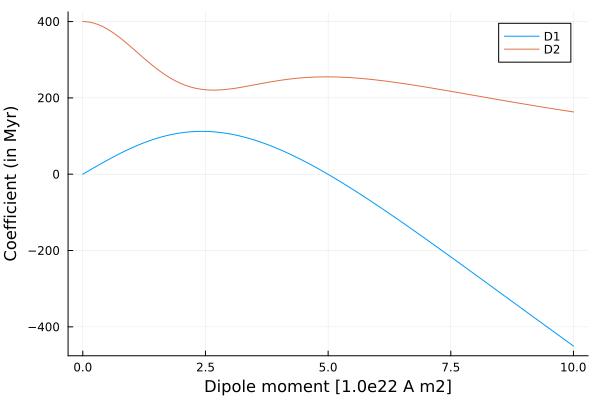

In [11]:
rate = 1/recurrence
An = moments(A,rate)

# define range of x for plotting
xplot = (0 : 0.1 : 10.0);
D1 = zeros(length(xplot))
D2 = zeros(length(xplot))
D3 = zeros(length(xplot))

# compute D1 and D2 at plotting points
for i = 1 : length(xplot)
    f = 1.0 / (1.0 + (xplot[i]/x0)^2);
    g = exp(-xplot[i]^2/1.8^2)
    D1[i] = -gamma*xplot[i] + An[1]*xplot[i]*f;
    D2[i] = 0.5*An[2]*(xplot[i]^2)*(f^2) + 0.5 * qp*g;
    D3[i] = (1/6.0) * An[3]*(xplot[i]^3)*(f^3);
end

plot(xplot,D1,label="D1",xlabel="Dipole moment [1.0e22 A m2]",ylabel="Coefficient (in Myr)")
plot!(xplot,D2,label="D2")
#plot(xplot,D3)

Save a plot of the drift and diffusion coefficients

In [18]:
savefig("Drift&Diffusion.pdf")